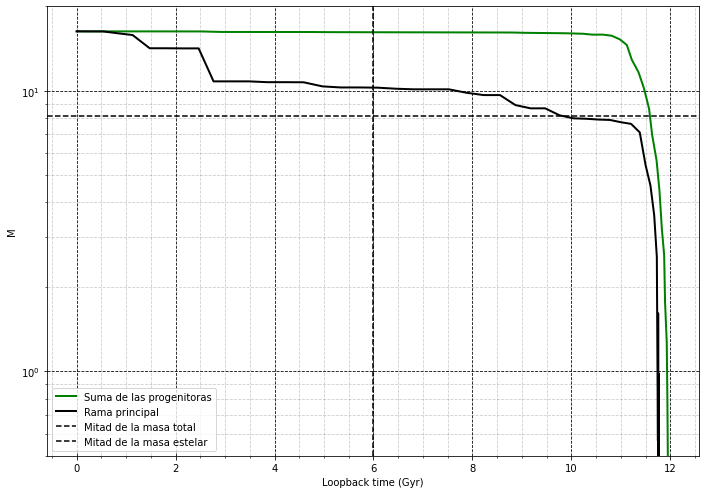

In [89]:
from os import getcwd

import matplotlib.pyplot as plt
from numpy import arange, log10, nan
import pandas as pd

fig, ax = plt.subplots(figsize=(11.69, 8.27))

main_df = pd.read_csv(getcwd() + '/datos/galaxias_13.csv')

# Obtiene el valor maximo y minimo de massWeightedAge
minWeightAge = min(main_df['massWeightedAge'])
maxWeightAge = max(main_df['massWeightedAge'])

# Divide en porciones
arrayWeightAge = arange(minWeightAge, maxWeightAge, 0.05)
longArrayWeightAge = arange(minWeightAge, maxWeightAge, 0.01)

# Obtiene los valores de masa del ultimo instante (step)
dfWeightAge = main_df[main_df['massWeightedAge'] > arrayWeightAge[-1]]
# Obtiene la fila de la galaxia con mas masa del ultimo instante
lastGalaxyRow = main_df[main_df['stellarMass'].isin([max(dfWeightAge['stellarMass'])])]

# Si tenemos dos valores (posiblemente por un error de redondeo obtenemos el mÃ¡s antiguo)
if lastGalaxyRow['treeId'].size != 1:
    lastGalaxyRow = lastGalaxyRow[lastGalaxyRow['massWeightedAge'].isin([max(lastGalaxyRow['massWeightedAge'])])]
    
#
# Obtenemos los valores del arbol
#
descendantId = lastGalaxyRow['galaxyID']
flag = True

descendant_ids_dict = {}
main_ids = []
main_snapnums = []
# Primera iteracion
temp_df = main_df[main_df['descendantId'].isin([descendantId])]
main_ids.append(int(descendantId))
descendant_ids_dict[int(descendantId)] = list(range(int(descendantId), int(temp_df['lastProgenitorId']), 1))
while flag:  
    nextGalaxyID = int(temp_df['galaxyID'])
    main_ids.append(nextGalaxyID)
    temp_df = main_df[main_df['descendantId'].isin([nextGalaxyID])]
    # Para el bucle si ya no hay datos
    if temp_df.empty:
        flag = False
        break
    descendant_ids_dict[nextGalaxyID] = list(range(int(nextGalaxyID), int(temp_df['lastProgenitorId']), 1))

#
# Obtenemos la masa y edad de la principal
# 
main_df = main_df[main_df['galaxyID'].isin(main_ids)]
total_df = pd.read_csv(getcwd() + '/datos_completos/galaxias_13.csv')

main_stellarMass = []
main_weightedAge = []
total_stellarMass = []
total_weightedAge = []

# Metodo snapnum a snapnum
for snapnum_ in main_df['snapnum'].tolist():
    # Corta los datos en mass = 10
    temp_main_df = main_df[main_df['snapnum'].isin([snapnum_])]
    main_stellarMass.append(float(temp_main_df['stellarMass']))
    main_weightedAge.append(float(temp_main_df['massWeightedAge']))

# Obtiene el valor final de la masa
last_stellarMass = main_stellarMass[:1][0]

# Invierte las edades
main_weightedAge = [abs(i - max(main_weightedAge)) for i in main_weightedAge]

#
# Total
#

# Metodo objeto a objeto
# for idx, row in total_df.iterrows():
#     total_stellarMass.append(float(row['stellarMass']))
#     total_weightedAge.append(float(row['massWeightedAge']))

# Metodo snapnum a snapnum
for snapnum_ in total_df['snapnum'].tolist():
    # Corta los datos en mass = 10
    temp_total_df = total_df[total_df['snapnum'].isin([snapnum_])]
    total_stellarMass.append(float(temp_total_df['stellarMass'].sum()))
    total_weightedAge.append(float(temp_total_df['massWeightedAge'].mean()))

# Metodo instante a instante
# for idx, age_ in enumerate(longArrayWeightAge[:-1]):
#     lower_weightedAge = age_
#     upper_weightedAge = longArrayWeightAge[idx+1]
#     # Obtiene los datos del instante temporal del branch principal
#     temp_total_df = total_df[total_df['massWeightedAge'] > lower_weightedAge]
#     temp_total_df = temp_total_df[upper_weightedAge > temp_total_df['massWeightedAge']]
#     # Agrega los valores de masa y edad a las listas del branch principal
#     if temp_total_df['stellarMass'].sum() is not nan:
#         total_stellarMass.append(temp_total_df['stellarMass'].sum())
#         total_weightedAge.append((lower_weightedAge+upper_weightedAge)/2)

total_weightedAge = [abs(i - max(total_weightedAge)) for i in total_weightedAge]

ax.set_yscale('log')
# Ordena las listas de todos los progenitores
total_lists = zip(*sorted(zip(total_weightedAge, total_stellarMass)))
total_weightedAge, total_stellarMass = (list(t) for t in total_lists)
# Corta en 0.5
final_total_weightedAge = []
final_total_stellarMass = []
for idx, stellarMass in enumerate(total_stellarMass):
    # if stellarMass > 0.5:
    if True:
        final_total_weightedAge.append(total_weightedAge[idx])
        final_total_stellarMass.append(stellarMass)
# Plotea todos los progenitores
ax.plot(final_total_weightedAge, final_total_stellarMass, linestyle='-',color='green', linewidth=2, label='Suma de las progenitoras')

# Ordena las listas de la rama principal
main_lists = zip(*sorted(zip(main_weightedAge, main_stellarMass)))
main_weightedAge, main_stellarMass = (list(t) for t in main_lists)
# Corta en 0.5
final_main_weightedAge = []
final_main_stellarMass = []
for idx, stellarMass in enumerate(main_stellarMass):
    # if stellarMass > 0.5:
    if True:
        final_main_weightedAge.append(main_weightedAge[idx])
        final_main_stellarMass.append(stellarMass)
# Plotea el branch principal
# ax.plot(final_main_weightedAge, final_main_stellarMass, linestyle='-',color='black')
ax.plot(final_main_weightedAge, final_main_stellarMass, linestyle='-',color='black', linewidth=2, label='Rama principal')

# Plotear cuando alcanza la mitad de la masa final
# Obtener la masa final
plt.axhline(y = last_stellarMass/2, color = 'black', linestyle = 'dashed', label= 'Mitad de la masa total') 

# Plotear cuando alcanza la mitad de la masa final
# Obtener la masa final
plt.axvline(x = 6, color = 'black', linestyle = 'dashed', label= 'Mitad de la masa estelar') 

# Pone nombre a los ejes
ax.set_xlabel('Loopback time (Gyr)')
ax.set_ylabel('M')

# ax.set_yticks(arange(0, 20))
ax.set_ylim([0.5,20])

# Crea el grid
plt.grid(b=True, which='major', color='black', linestyle='dashed')
plt.grid(b=True, which='minor', color='black', linestyle='dashed', alpha=0.2)
plt.minorticks_on()

# Activa la leyenda
plt.legend()

# Guarda la figura
plt.savefig('final.jpg')